# Pneumonia X-Ray Detection with Tensorflow -- Joseph Kim

### Part 1 -- Data Preparation

In [1]:
import os
import zipfile
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [2]:
# from online: just use to extract datasets from zipfile
with zipfile.ZipFile("train.zip", 'r') as zip_ref:
        zip_ref.extractall()

EDA: Load and display 3 images from each dataset

In [3]:
def display_images():
    normal_images = [os.path.join("train/NORMAL", img) for img in os.listdir("train/NORMAL")[:3]] # using for loop in os to obtain 3 images from NORMAL dataset
    pneumonia_images = [os.path.join("train/PNEUMONIA", img) for img in os.listdir("train/PNEUMONIA")[:3]]
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 8)) # create 6 subplots,use matplotlib to display 3 images using load_img
    for i, img_path in enumerate(normal_images):
        img = load_img(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title("Normal")

    for i, img_path in enumerate(pneumonia_images):
        img = load_img(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title("Pneumonia")

    plt.show()

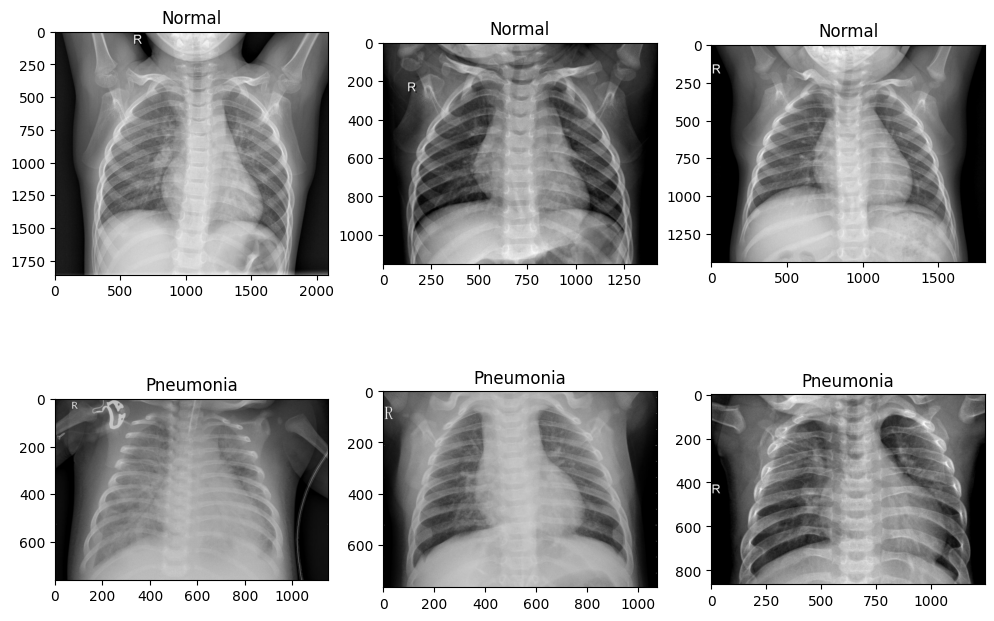

In [4]:
display_images()

Data Preprocessing and Training: Resizing all images to 64 x 64 and normalizing, then train_test_split

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
images, labels = [], []
    
for label, folder_path in enumerate(["train/NORMAL", "train/PNEUMONIA"]):  # use 0 for normal, 1 for pneumonia
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = load_img(img_path, target_size=(64, 64))  # resize to 64x64 through target_size
        img_array = img_to_array(img) / 255.0  # to normalize, divide each pixel value by 255
        images.append(img_array)
        labels.append(label)
    
images = np.array(images)
labels = np.array(labels)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=69)
    
print("Training data shape: " + str(X_train.shape) + ", Validation data shape: " + str(X_val.shape)) # 80-20 split, all 64x64 images

Training data shape: (4172, 64, 64, 3), Validation data shape: (1044, 64, 64, 3)


Plotting the class distribution

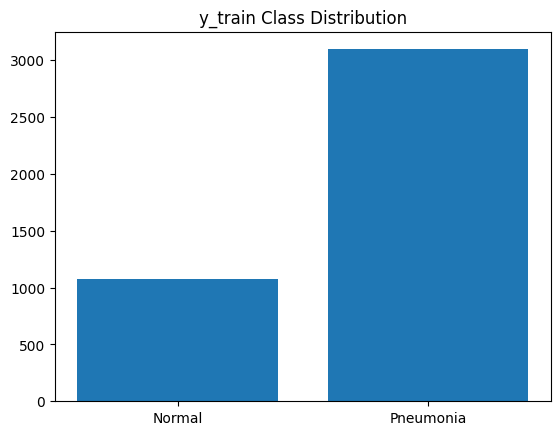

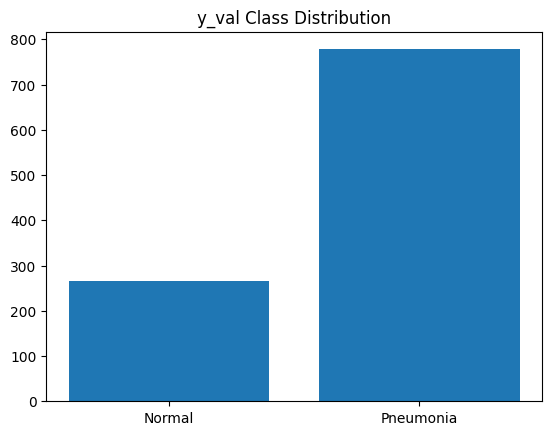

In [8]:
unique, counts = np.unique(y_train, return_counts=True) # returns all unique elements in the y_train array and corresponding counts
plt.bar(["Normal", "Pneumonia"], counts)
plt.title("y_train Class Distribution")
plt.show()

unique, counts = np.unique(y_val, return_counts=True) # returns all unique elements in the y_val and corresponding counts
plt.bar(["Normal", "Pneumonia"], counts)
plt.title("y_val Class Distribution")
plt.show()
# should note the class imbalance

Balancing the Training Dataset with Downsampling

In [9]:
from sklearn.utils import resample

In [10]:
normal_indices = np.where(y_train == 0)[0] # use this to separate the indices for both classes
pneumonia_indices = np.where(y_train == 1)[0]

n_normal = len(normal_indices)
n_pneumonia = len(pneumonia_indices)

In [11]:
print(n_normal, n_pneumonia) # original numbers

1075 3097


In [12]:
# using resample to downsample the indices with no replacement, making n_pneumonia = n_normal
pneumonia_downsampled_indices = resample(pneumonia_indices, replace=False,  n_samples=n_normal,  random_state=69)

In [13]:
balanced_indices = np.concatenate([normal_indices, pneumonia_downsampled_indices])

X_train_balanced = X_train[balanced_indices]
y_train_balanced = y_train[balanced_indices]

In [14]:
n_balanced_normal = np.sum(y_train_balanced == 0)
n_balanced_pneumonia = np.sum(y_train_balanced == 1)

Plotting the balanced class distribution

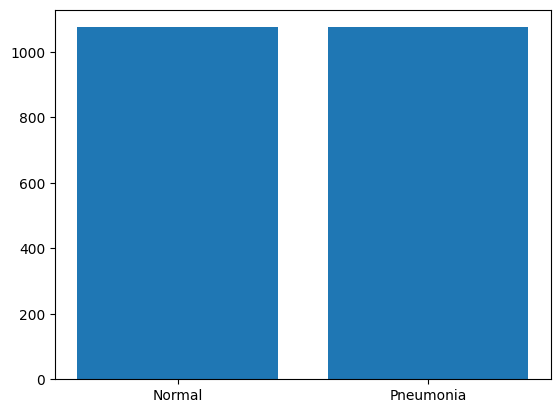

In [15]:
unique, counts = np.unique(y_train_balanced, return_counts=True)
plt.bar(["Normal", "Pneumonia"], counts)
plt.show() # now they are equal in number

### Model Building with Tensorflow and Keras

Defining the CNN architecture

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

One Hot Encoding: Should be noted that 'int' data-type does not work for training, so one-hot encode in advance

In [17]:
y_train_balanced = to_categorical(y_train_balanced, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

Building the CNN model

In [18]:
# following the guidelines from the instructions
model = Sequential()

model.add(InputLayer(input_shape=(64, 64, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.summary()

c:\Users\josep\miniconda3\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,410 (6.20 MB)

 Trainable params: 1,625,410 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# train the model
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=20,  
    batch_size=64,  
    verbose=1
)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.5598 - loss: 0.8065 - val_accuracy: 0.9042 - val_loss: 0.3852
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.8788 - loss: 0.3297 - val_accuracy: 0.9435 - val_loss: 0.1376
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9323 - loss: 0.1703 - val_accuracy: 0.9368 - val_loss: 0.1764
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9476 - loss: 0.1505 - val_accuracy: 0.9377 - val_loss: 0.1713
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9578 - loss: 0.1178 - val_accuracy: 0.9617 - val_loss: 0.1178
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9552 - loss: 0.1330 - val_accuracy: 0.9598 - val_loss: 0.1082
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9669 - loss: 0.0893 - val_accuracy: 0.9387 - val_loss: 0.1509
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9640 - loss: 0.1072 - val_accuracy: 0.9626 - 

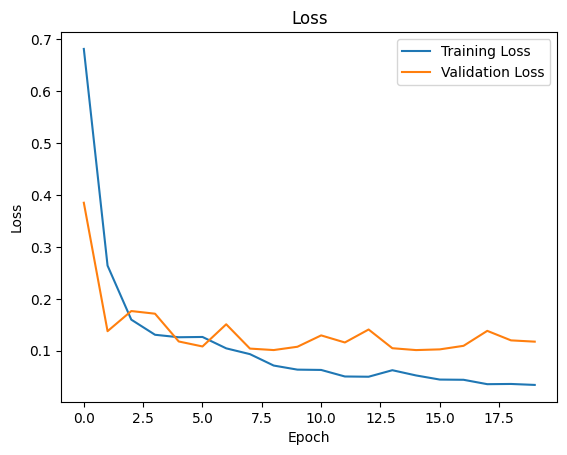

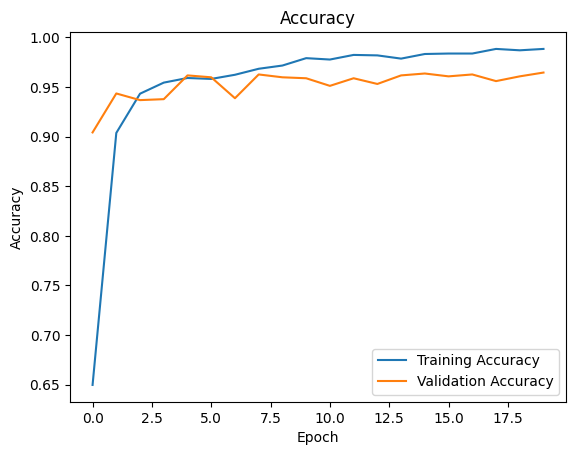

In [21]:
#visualizing the training process
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It is clear from the plots that both the training loss and the validation loss decrease consistently over each epoch, indicating a steadily improving model. However, validation loss is consistently more than the training loss (and fluctuates more towards the end epochs), suggesting that there is some overfitting. This is also supported by the accuracy plot. 

In both the training accuracy and validation accuracy, the accuracies improve steadily almost reaching 100%, but the validation accuracy is slightly lower than the training accuracy, supporting the idea of overfitting.

### Hyperparameter Training and Model Evaluation

Varying hyperparamters

In [22]:
# hyperparameter combinations from instructions
batch_sizes = [16, 32, 64]
filter_sizes = [(3, 3), (5, 5), (7, 7)]
num_filters_options = [(32, 64), (64, 128)]

In [23]:
def create_model(filter_sizes, num_filters): # copying the CNN above and putting into a function
    model = Sequential()

    model.add(InputLayer(input_shape=(64, 64, 3)))
    model.add(Conv2D(num_filters[0], filter_sizes[0], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(num_filters[1], filter_sizes[1], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))
    return model

In [24]:
results = [] # create an empty array for numerical results

In [25]:
# for each combination of batch size, filter size, and number of filters, create model, train model, and store the results
for batch_size in batch_sizes:
    for filter_size in filter_sizes:
        for num_filters in num_filters_options:
            
            # create the model
            model = create_model(filter_size, num_filters)
            model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
            
            # train the model
            history = model.fit(
                X_train_balanced, y_train_balanced,
                validation_data=(X_val, y_val),
                epochs=20,
                batch_size=batch_size,
                verbose=1
            )
            
            # store the results
            final_val_accuracy = history.history['val_accuracy'][-1]
            results.append({
                'batch_size': batch_size,
                'filter_size': filter_size,
                'num_filters': num_filters,
                'val_accuracy': final_val_accuracy,
                'history': history.history
            })

Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7485 - loss: 0.4935 - val_accuracy: 0.9339 - val_loss: 0.1768
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9534 - loss: 0.1384 - val_accuracy: 0.8659 - val_loss: 0.3452
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9517 - loss: 0.1431 - val_accuracy: 0.8477 - val_loss: 0.3995
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9640 - loss: 0.1265 - val_accuracy: 0.9138 - val_loss: 0.2551
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9602 - loss: 0.1125 - val_accuracy: 0.9674 - val_loss: 0.1021
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9726 - loss: 0.0755 - val_accuracy: 0.9636 - val_loss: 0.1134
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9772 - loss: 0.0615 - val_accuracy: 0.9511 - val_loss: 0.1593
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9821 - loss: 0.0411 - val_accu

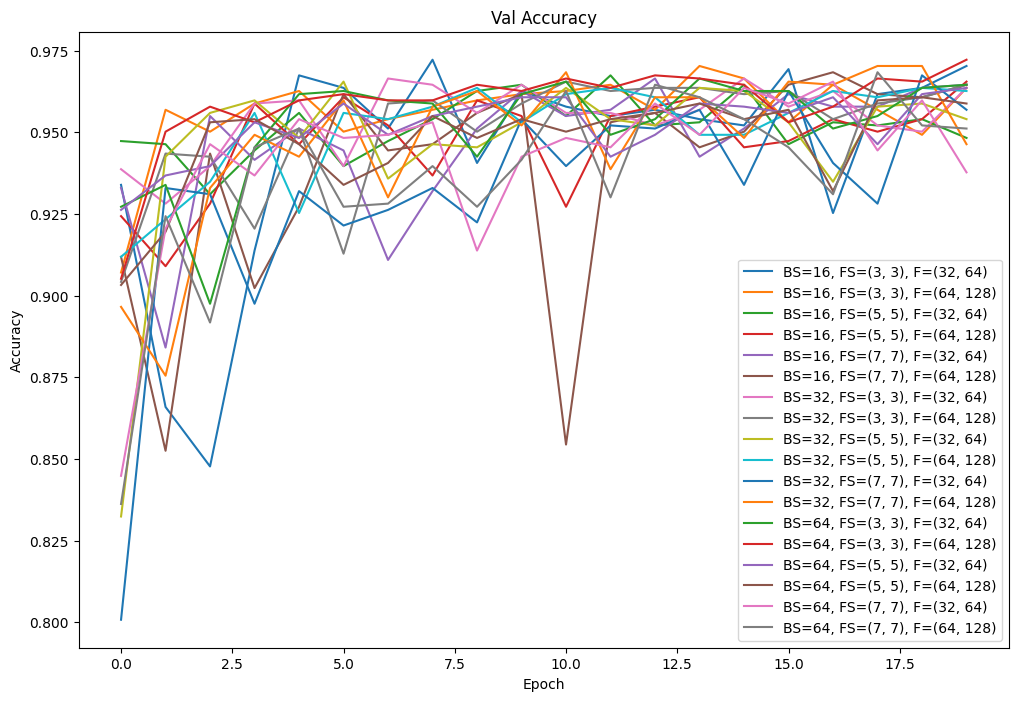

In [26]:
plt.figure(figsize=(12, 8))
for res in results:
    plt.plot(res['history']['val_accuracy'], label=f"BS={res['batch_size']}, FS={res['filter_size']}, F={res['num_filters']}")
    
plt.title("Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [27]:
#print(results)

The validation accuracy trends indicate strong performance across almost every configuration, with final accuracies ranging from ~0.94 to ~0.97. Smaller batch sizes (16) often resulted in noisier trends but higher peaks, while larger batch sizes (64) showed smoother, more stable validation curves. Models with larger filter sizes (7, 7) and more filters sometimes overfit slightly but still achieved high validation scores. While hard to determine exactly from the plots, the validation loss trends were generally consistent, showing well-fitted models with some overfitting most of the time. 

Overall, the best configurations balanced stability and high accuracy, indicating a tradeoff between model complexity and generalization.

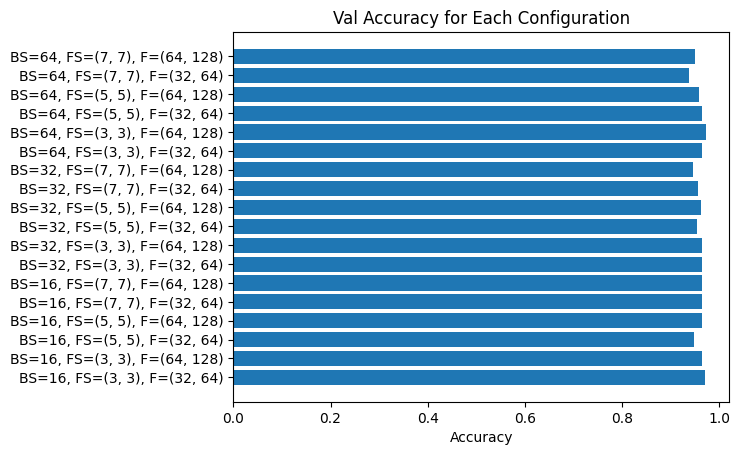

In [28]:
# bar plot for validation accuracy
configurations = [f"BS={res['batch_size']}, FS={res['filter_size']}, F={res['num_filters']}" for res in results]
accuracies = [res['val_accuracy'] for res in results]

plt.figure()
plt.barh(configurations, accuracies)
plt.xlabel("Accuracy")
plt.title("Val Accuracy for Each Configuration")
plt.show()

In [29]:
sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True) # sort results based on best validation accuracy
#print(sorted_results)

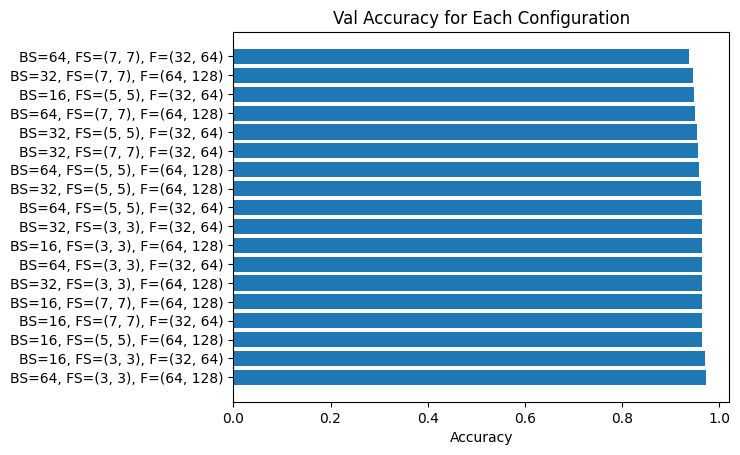

In [30]:
# bar plot for validation accuracy
configurations = [f"BS={res['batch_size']}, FS={res['filter_size']}, F={res['num_filters']}" for res in sorted_results]
accuracies = [res['val_accuracy'] for res in sorted_results]

plt.figure()
plt.barh(configurations, accuracies)
plt.xlabel("Accuracy")
plt.title("Val Accuracy for Each Configuration")
plt.show()

In [31]:
best_model = sorted_results[0] # batch size 32, filter size (7, 7), num_filters = (32, 64)
worst_model = sorted_results[-1] # batch size 16, filter size (7, 7), num_filters = (64, 128)

#print("Best Model: " + str(best_model)) -- Best Model: 'batch_size': 32, 'filter_size': (7, 7), 'num_filters': (32, 64), 'val_accuracy': 0.9664750695228577
#print("Worst Model: " + str(worst_model)) -- Worst Model: 'batch_size': 16, 'filter_size': (7, 7), 'num_filters': (64, 128), 'val_accuracy': 0.9396551847457886

The two best models are (BS=32, FS=(7, 7), F=(32, 64)) and (BS=64, FS=(7, 7), F=(32, 64)) and the two worst models are (BS=16, FS=(7, 7), F=(64, 128)) and (BS=16, FS=(3, 3), F=(32, 64)).

The two best models, performed well likely because the larger filters (7x7) captured broad contextual features. Moderate to large batch sizes (32, 64) smoothed parameter updates, further improving generalization but also taking the longest amount of time. Further, when the amount of filters was limited to only (32, 64), the model's complexity is limited during training, preventing overitting. Both model's performances indicate that for this dataset, capturing broader features is more critical than extracting highly detailed patterns, especially when paired with appropriate regularization and optimization dynamics.

The two worst models, struggled due to overfitting risks and inadequate feature extraction. Both of these models have the smallest batch size (16), meaning each update at the epoch was noisier than if the batch size was increased. The first model's high filter count and small batch size increased the complexity, leading to overfitting. In contrast, the second model's small filters (3x3) and limited filters may have missed important broader features. 

Additional factors impacting the outcomes include the dataset size, class imbalance, and regularization. A smaller dataset amplifies the risk of overfitting, especially for complex models with many parameters. Class imbalance may cause the model to favor the majority class, skewing performance metrics. Though in this assignment, we balanced the classes, this also made the NORMAL dataset significantly smaller. Regularization techniques, such as dropout used in my model's CNN architecture, can mitigate overfitting but must be balanced with model complexity in order to be effective. Learning rate and optimizer choice (not sure about other ones besides Adam) also influence convergence and stability.